In [1]:
### replicate results of EVmutation with the PABP_YEAST dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy
from collections import OrderedDict
from sklearn.svm import OneClassSVM
from datetime import datetime


In [2]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
np.random.seed(0)

In [3]:
# helper functions
def encode(seqs, alphabet=ALPHABET_PROTEIN):
    '''
    Go from letters to numbers
    '''
    aa_to_i = OrderedDict((aa, i) for i, aa in enumerate( alphabet ))
    X = np.asarray([[aa_to_i[x] for x in seq] 
                    for seq in seqs])
    return X, aa_to_i
def one_hot_encode(s):
    return np.vstack([np.zeros(20), np.eye(20)])[s].flatten()

def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True
def process_msa_sequence(msa_sequences):
    ''' takes in list of sequences and one-hot encodes the sequences'''
    pos_upper = [x for x in range(len(msa_sequences[0])) if not msa_sequences[0][x].islower()]
    msa_sequences = np.asarray([np.asarray(list(s))[pos_upper] for s in msa_sequences if not 'x' in s])
    msa_sequences = np.asarray([s for s in msa_sequences if check_sequence(s) and len(s)==82])
    msa_sequences = np.asarray(msa_sequences)

    seqs_enc, aa_to_i = encode(msa_sequences)
    oh_enc_seq = []
    for s in seqs_enc:
        oh_enc_seq.append(one_hot_encode(s))
    oh_enc_seq = np.asarray(oh_enc_seq)
    return oh_enc_seq

def valid_weights_from_model(c):
    ### returns only valid weights
    _w = c.weights
    _w_valid = []
    for i in range(c.weights.shape[0]):
        if _w[i] == 0: 
            continue
        _w_valid.append(1/_w[i])
    return _w_valid

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Preprocessing sequence data

In [4]:
### get all available msa sequences
yeast_seq_str = []
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
for fasta in fasta_sequences:
    yeast_seq_str.append(str(fasta.seq))

processed = process_msa_sequence(yeast_seq_str)
c = CouplingsModel(f"PABP_YEAST/model/PABP_YEAST.model_params")
weights = valid_weights_from_model(c)
assert len(weights) == len(processed)
wildtype_processed, wildtype_weights = processed[0], weights[0]
processed, weights = np.asarray(processed[1:]), np.asarray(weights[1:])
processed, weights = unison_shuffled_copies(processed, weights)

In [5]:
# using the trained svm model on DMS data
wildtype = yeast_seq_str[0]
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
mutant, label_dms = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mutant_data.append(wildtype[:loc]+mutant_aa+wildtype[loc+1:])
mutant_data = np.asarray(mutant_data)
mutant_data = process_msa_sequence(mutant_data)

mutant_data, label_dms = np.asarray(mutant_data), np.asarray(label_dms)
mutant_data, label_dms = unison_shuffled_copies(mutant_data, label_dms)

label = np.zeros(label_dms.shape[0])
for i in range(label_dms.shape[0]):
    label[i] = 1 if label_dms[i] > 0.6 else 0


(array([120.,  60.,  37.,  31.,  27.,  33.,  24.,  29.,  29.,  27.,  51.,
         45.,  47.,  76.,  88., 105., 123., 125.,  61.,  25.,  16.,   3.,
          1.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00947484, 0.06666092, 0.12384699, 0.18103307, 0.23821914,
        0.29540522, 0.35259129, 0.40977737, 0.46696344, 0.52414952,
        0.58133559, 0.63852167, 0.69570775, 0.75289382, 0.8100799 ,
        0.86726597, 0.92445205, 0.98163812, 1.0388242 , 1.09601027,
        1.15319635, 1.21038242, 1.2675685 , 1.32475457, 1.38194065,
        1.43912672, 1.4963128 , 1.55349887, 1.61068495, 1.66787102,
        1.7250571 , 1.78224317, 1.83942925, 1.89661532, 1.9538014 ,
        2.01098747, 2.06817355, 2.12535962, 2.1825457 , 2.23973177,
        2.29691785, 2.35410392, 2.41129   , 2.46847607, 2.52566215,
        2.58284822, 2.6400343 , 2.69722037, 2.

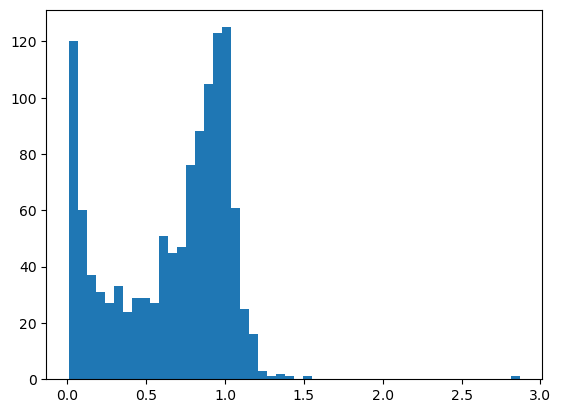

In [6]:
### this dataset actually shows bimodality
plt.hist(label_dms, bins=50)

Experiment 1: Train a OneClassSVM with polynomial degree 2 kernel on MSA sequences. 

In [ ]:
### The classifier has some effect on MSA data. ~2700 out of 5000 total positive samples have been classified correctly from the MSA dataset

clf = OneClassSVM(kernel='poly', degree=2, nu=0.3)
train = processed[:50000]
clf.fit(train, sample_weight=weights[:50000])
pred = clf.predict(processed[50000:55000])
print(pred[np.where(pred==1)].shape)

In [43]:
### The classifier does shitty job for mutant sequences (DMS).
mutant_pred = clf.predict(mutant_data)
print(pred[np.where(mutant_pred==1)].shape)

NameError: name 'clf' is not defined

Experiment 2: Train a OneClassSVM with polynomial degree 2 kernel on DMS sequences.

In [44]:
### also does a shitty job. Probably because too many features and did not shuffle sequences.
import sklearn
clf2 = sklearn.svm.SVC(kernel='poly', degree=2)
split = mutant_data.shape[0]//5 * 4
mut_train = mutant_data[:split]
mut_test = mutant_data[split:]
clf2.fit(mut_train, label[:split])

NameError: name 'pred' is not defined

Experiement 3: Gaussian Kernel OneClassSVM

In [10]:
clf = OneClassSVM(kernel='rbf', nu=0.3)
train = processed[:50000]
clf.fit(train, sample_weight=weights[:50000])
pred = clf.predict(processed[50000:55000])
print(pred[np.where(pred==1)].shape)

(3552,)


In [12]:
### The classifier does shitty job for mutant sequences (DMS).
mutant_pred = clf.predict(mutant_data)
print(pred[np.where(mutant_pred==1)].shape)

(1188,)


Experiement 4: explicitly model pairwise features. the original d features become d^2 features. SVM still uses poly deg-2 kernel

In [7]:
d = processed.shape[1]
num_seq = processed.shape[0]
rich_msa = np.zeros((num_seq//10, d**2))

print(d, num_seq, rich_msa.shape)

1640 151495 (15149, 2689600)


In [8]:
# explicitly model pairwise interactions as features. This cell takes more than 1 hour to run
for seq in range(num_seq//10):
    for i in range(d):
        for j in range(i, d):
            if processed[seq][i] == 1 and processed[seq][j] == 1 or i == j:
                rich_msa[seq][i*d + j] = 1
rich_msa = scipy.sparse.csr_matrix(rich_msa, (num_seq//10, d**2))

test = np.zeros((mutant_data.shape[0], d**2))
for seq in range(mutant_data.shape[0]):
    for i in range(d):
        for j in range(i, d):
            if mutant_data[seq][i] == 1 and mutant_data[seq][j] == 1 or i == j:
                test[seq][i*d + j] = 1

test_sparse = scipy.sparse.csr_matrix(test, (mutant_data.shape[0], d**2))


In [ ]:
import pickle

with open("store_rich_msa.obj", "wb") as file:
    pickle.dump(rich_msa, file)

with open("store_rich_test.obj", "wb") as file:
    pickle.dump(test_sparse, file)

with open("store_rich_weights.obj", "wb") as file:
    pickle.dump(weights, file)

with open("store_test_label.obj", "wb") as file:
    pickle.dump(label, file)

with open("store_test_label_dms.obj", "wb") as file:
    pickle.dump(label_dms, file)

# rich_msa, test_sparse = None, None
# label, label_dms, weights = None, None, None
# with open("store_rich_msa.obj", "rb") as file:
#     rich_msa = pickle.load(file)

# with open("store_rich_test.obj", "rb") as file:
#     test_sparse = pickle.load(file)

# with open("store_rich_weights.obj", "rb") as file:
#     weights = pickle.load(file)

# with open("store_test_label.obj", "rb") as file:
#     label = pickle.load(file)

# with open("store_test_label_dms.obj", "rb") as file:
#     label_dms = pickle.load(file)
    
# assert rich_msa.shape[1] == test_sparse.shape[1]
# assert label.shape[0] == test_sparse.shape[0]

# ### expand wildtype
wt = [0 for _ in range(d**2)]
for i in range(d):
    for j in range(i, d):
        if wildtype_processed[i] == 1 and wildtype_processed[j] == 1 or i == j:
            wt[i*d + j] = 1

In [12]:
# for n in [0.1, 0.15, 0.2, 0.25, 0.3]:
#     clf = OneClassSVM(kernel='linear', nu=n)
#     clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
#     pred = clf.predict(test_sparse)
#     cnt = 0 
#     for i in range(mutant_data.shape[0]):
#         if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
#             cnt += 1
#     print(f'kernel: linear, nu: {n}, result: ', cnt)
#     print('wt: ', clf.predict([wt]))

# ### prediction of wildtype
# wt = [0 for _ in range(d**2)]
# for i in range(d):
#     for j in range(i, d):
#         if wildtype_processed[i] == 1 and wildtype_processed[j] == 1 or i == j:
#             wt[i*d + j] = 1
# clf.predict([wt])

Experiment 4.1: Hyperparameter tuning

In [ ]:
for n in [0.2, 0.201, 0.202, 0.21, 0.22, 0.23, 0.25, 0.28, 0.3]:
    for deg in [1, 2, 3]:
        clf = OneClassSVM(kernel='poly', degree = deg, nu=n)
        clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
        pred = clf.predict(test_sparse)
        cnt = 0 
        for i in range(mutant_data.shape[0]):
            if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
                cnt += 1
        print(f'kernel: poly, degree: {deg}, nu: {n}, result: ', cnt)
        print(pred[:20])
        print("wild type pred: ", clf.predict([wt]))
    
    clf = OneClassSVM(kernel='rbf', nu=n)
    clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
    pred = clf.predict(test_sparse)
    cnt = 0 
    for i in range(mutant_data.shape[0]):
        if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
            cnt += 1
    
    print(f'kernel: rbf, nu: {n}, result: ', cnt)
    print(pred[:20])
    print("wild type pred: ", clf.predict([wt]))

    clf = OneClassSVM(kernel='sigmoid', nu=n)
    clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
    pred = clf.predict(test_sparse)
    cnt = 0 
    for i in range(mutant_data.shape[0]):
        if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
            cnt += 1
    print(f'kernel: rbf, nu: {n}, result: ', cnt)
    print(pred[:20])
    print("wild type pred: ", clf.predict([wt]))


Results:
    Only (kernel = 'rbf', nu = 0.2) and (kernel = 'rbf', nu = 0.3) produced results in which the prediction of mutant sequences were not all 1's or all -1's. For nu = 0.2, 716 sequences were classified correctly. For nu = 0.3, 543 sequences were classified correctly. There are a total of 673 (pos) + 515 (neg) = 1188 sequences. 

Experiement 4.2: Look into the weights assigned to each feature in the linear model, see if SVM has learned anything interesting about pairwise weights. Compare with the Potts model.

In [16]:
NAME="PABP_YEAST"
# load parameters from file to create a pairwise model
c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")

potts_params = c.J_ij
print(potts_params.shape)

potts_weights_arr = np.zeros(2689600)
for i in range(82):
    for aa1 in range(20):
        for j in range(i, 82):
            for aa2 in range(20):
                potts_weights_arr[(i*20 + aa1) * d + j*20 + aa2] = c.J_ij[i][j][aa1][aa2]


(82, 82, 20, 20)


In [13]:
# test_sparse = scipy.sparse.csr_matrix(test_sparse, (test_sparse.shape[0], d**2))
# rich_msa = scipy.sparse.csr_matrix(rich_msa, (rich_msa.shape[0], d**2))

In [29]:
test_sparse = np.asarray(test_sparse)

In [30]:
rich_msa = np.asarray(rich_msa)

In [32]:
# [0.0000000000000000001, 0.0000000000000000002, 0.000000000000000001, 0.000000000000000002, 0.00000000000000001, 0.00000000000000002, 
#         0.0000000000000001, 0.0000000000000002, 0.000000000000001, 0.000000000000002, 0.00000000000001, 0.00000000000002, 0.0000000000001, 
#         0.0000000000002, 0.000000000001, 0.000000000002, 0.00000000001, 0.00000000002, 0.0000000001, 0.0000000002, 0.000000001, 0.000000002,
#         0.00000001, 0.000000002, 0.00000001, 0.00000002, 0.0000001, 0.0000002, 0.000001]

In [34]:
# train a linear model, which should theoretically be similar to the potts model.

with open('result.txt', 'a') as file:
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    for n in [0.00000000000001, 0.00000000000002, 0.0000000000001, 
        0.0000000000002, 0.000000000001, 0.000000000002, 0.00000000001, 0.00000000002, 0.0000000001, 0.0000000002, 0.000000001, 0.000000002,
        0.00000001, 0.000000002, 0.00000001, 0.00000002, 0.0000001, 0.0000002, 0.000001]:
        clf = OneClassSVM(kernel='linear', nu=n)
        clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
        pred = clf.predict(test_sparse)
        cnt = 0 
        for i in range(test_sparse.shape[0]):
            if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
                cnt += 1
        print(f'kernel: linear, nu: {n}, result: ', cnt)
        file.write(f'kernel: linear, nu: {n}, result: {cnt}\n')
        print(pred[:20])
        file.write('\n')
        print(np.sum(pred))
        file.write(f'Sum: {np.sum(pred)}\n')
        print("wild type pred: ", clf.predict([wt]))
        file.write(f'wild type pred : {clf.predict([wt])}\n')
        w = clf.coef_
        w = w.flatten()

        sprm = scipy.stats.spearmanr(w, potts_weights_arr)
        print(f'spearman for nu = {n} is: {sprm}')
        file.write(f'spearman for nu = {n} is: {sprm}\n\n\n')

kernel: linear, nu: 1e-14, result:  515
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
-1188
wild type pred:  [-1]
spearman for nu = 1e-14 is: SpearmanrResult(correlation=0.006269996877253153, pvalue=8.416429103887442e-25)
kernel: linear, nu: 2e-14, result:  515
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
-1188
wild type pred:  [-1]
spearman for nu = 2e-14 is: SpearmanrResult(correlation=0.006269996877253153, pvalue=8.416429103887442e-25)
kernel: linear, nu: 1e-13, result:  515
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
-1188
wild type pred:  [-1]
spearman for nu = 1e-13 is: SpearmanrResult(correlation=0.006269996877253153, pvalue=8.416429103887442e-25)
kernel: linear, nu: 2e-13, result:  515
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
-1188
wild type pred:  [-1]
spearman for nu = 2e-13 is: SpearmanrResult(correlation=0.006269996877253153, pvalue=8.416429103887442e-25)
kernel: linear, nu: 1e-12, result:  515
[-1 -1 -

Experiment 4.3: Remove sequence weights during training. In addition, inspect the effects of classification on MSA data.

In [9]:
# train a linear model, which should theoretically be similar to the potts model.

with open('result.txt', 'a') as file:
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    for n in [0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5]:
        clf = OneClassSVM(kernel='linear', nu=n)
        clf.fit(rich_msa)
        pred = clf.predict(test_sparse)
        cnt = 0 
        for i in range(mutant_data.shape[0]):
            if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
                cnt += 1
        print(f'kernel: linear, nu: {n}, result: ', cnt)
        file.write(f'kernel: linear, nu: {n}, result: {cnt}\n')
        print(pred[:20])
        file.write('\n')
        print(np.sum(pred))
        file.write(f'Sum: {np.sum(pred)}\n')
        print("wild type pred: ", clf.predict([wt]))
        file.write(f'wild type pred : {clf.predict([wt])}\n')
        w = clf.coef_.toarray()
        w = w.flatten()

        sprm = scipy.stats.spearmanr(w, potts_weights_arr)
        print(f'spearman for nu = {n} is: {sprm}')
        file.write(f'spearman for nu = {n} is: {sprm}\n\n\n')

kernel: linear, nu: 0.001, result:  673
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
wild type pred:  [1]
spearman for nu = 0.001 is: SpearmanrResult(correlation=0.07970207311834936, pvalue=0.0)
kernel: linear, nu: 0.002, result:  673
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
wild type pred:  [1]
spearman for nu = 0.002 is: SpearmanrResult(correlation=0.07970209821992619, pvalue=0.0)
kernel: linear, nu: 0.01, result:  673
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
wild type pred:  [1]
spearman for nu = 0.01 is: SpearmanrResult(correlation=0.08238456212570854, pvalue=0.0)
kernel: linear, nu: 0.02, result:  673
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
wild type pred:  [1]
spearman for nu = 0.02 is: SpearmanrResult(correlation=0.0849834228805321, pvalue=0.0)
kernel: linear, nu: 0.1, result:  673
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1188
wild type pred:  [1]
spearman for nu = 0.1 is: SpearmanrResult(correlation=0.0937657773622651, pvalue=0.0)
kernel: linear, nu: 0.2, 

Experiment 4.4: Use Random Sequences as negatives

In [ ]:
n_random = 10000
random_str = [np.random.choice(list(ALPHABET_PROTEIN), 81) for _ in range(n_random)]
p_random = process_msa_sequence(random_str)

(2689600,)

In [ ]:
rich_random = np.zeros((n_random, d**2))

for seq in range(n_random):
    for i in range(d):
        for j in range(i, d):
            if p_random[seq][i] == 1 and p_random[seq][j] == 1 or i == j:
                rich_random[seq][i*d + j] = 1
rich_random = scipy.sparse.csr_matrix(rich_random, (n_random, d**2))

In [ ]:
clf_two_class = sklearn.svm.SVC(kernel='linear')

In [32]:
# w = clf.coef_.toarray()
# w = w.flatten()

sprm = scipy.stats.spearmanr(w, potts_weights_arr)
print(f'spearman for nu = {n} is: {sprm}')

spearman for nu = 0.001 is: SpearmanrResult(correlation=0.08430774677159406, pvalue=0.0)


In [11]:
label

array([0., 1., 1., ..., 0., 1., 1.])

Experiment 4.5: Check for correlation between decision function and labels

In [ ]:
# train a linear model, which should theoretically be similar to the potts model.

with open('result.txt', 'a') as file:
    file.write("Experiment 4.5: Check for correlation between decision function and labels")
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    for n in [0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5]:
        clf = OneClassSVM(kernel='linear', nu=n)
        clf.fit(rich_msa, sample_weight=weights[:rich_msa.shape[0]])
        pred = clf.decision_function(test_sparse)
        cnt = 0 
        for i in range(mutant_data.shape[0]):
            if (pred[i]== 1 and label[i] == 1) or (pred[i] == -1 and label[i] == 0):
                cnt += 1
        print(f'kernel: linear, nu: {n}, result: ', cnt)
        file.write(f'kernel: linear, nu: {n}, result: {cnt}\n')
        print(pred[:20])
        file.write('\n')
        print(np.sum(pred))
        file.write(f'Sum: {np.sum(pred)}\n')
        print("wild type pred: ", clf.predict([wt]))
        file.write(f'wild type pred : {clf.predict([wt])}\n')
        w = clf.coef_.toarray()
        w = w.flatten()

        sprm = scipy.stats.spearmanr(w, potts_weights_arr)
        print(f'spearman for nu = {n} is: {sprm}')
        file.write(f'spearman for nu = {n} is: {sprm}\n\n\n')